# Demo: CNN
Demostrate typical usages for debugging a Convolutional Neural Network

### Prepare pre-trained model

Using cache found in /home/ying/.cache/torch/hub/pytorch_vision_v0.10.0


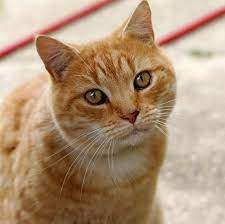

tiger cat 0.26326513290405273
Egyptian cat 0.18582996726036072
tabby 0.09715715050697327
lynx 0.014942376874387264
Persian cat 0.003323270007967949


In [1]:
import torch
import torchvision
import os
from PIL import Image
from torchvision import transforms

model = torch.hub.load(
    "pytorch/vision:v0.10.0",
    "resnet50",
    weights=torchvision.models.ResNet50_Weights.DEFAULT,
)
model.eval()
input_image = Image.open(os.path.join("..", "data", "cat.jpg"))
display(input_image)

preprocess = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_tensor = preprocess(input_image)
input_tensor_normed = norm(input_tensor)
input_batch = input_tensor_normed.unsqueeze(
    0
)  # create a mini-batch as expected by the model

with torch.no_grad():
    output = model(input_batch)
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
# Read the categories
with open(os.path.join("..", "data", "imagenet_classes.txt"), "r") as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

### Input gradients and visualization

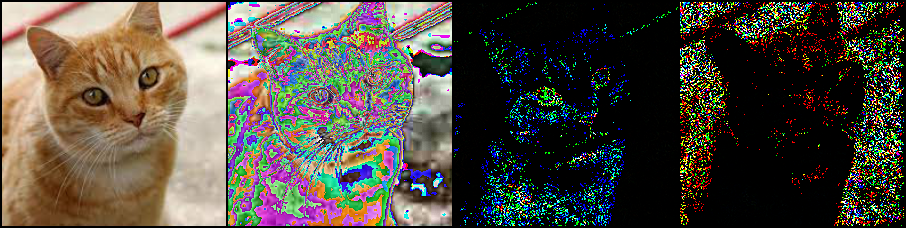

In [2]:
from diagnostics import get_input_gradients
from matplotlib import pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import make_grid

# Use zero img as baseline
# baseline = torch.zeros((1, 3, 224, 224))
baseline = None
target = torch.zeros((1, 1000))
# Use top1 class label as target
target[0][top5_catid[0]] = 1
input_grad = get_input_gradients(model, input_batch, baseline, target)
# Visualizations
grad_pos = input_grad[0].detach() * (input_grad[0] > 0) * input_batch[0].detach()
grad_neg = input_grad[0].detach() * (input_grad[0] < 0) * input_batch[0].detach()
grid = make_grid([input_tensor.detach(), input_batch[0].detach(), grad_pos, grad_neg])
display(F.to_pil_image(grid))

### Integrated gradients and visualization

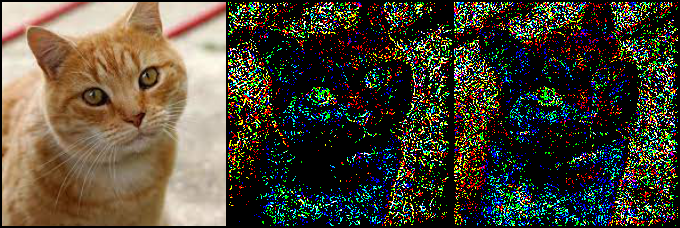

In [3]:
from diagnostics import get_integrated_gradients

integraded_grad = get_integrated_gradients(model, input_batch, baseline, target, 50)
# Visualizations
grid = make_grid(
    [input_tensor.detach(), integraded_grad[0], input_grad[0] * input_batch[0].detach()]
)
display(F.to_pil_image(grid))